In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

test_ids = test["id"]

y = train["Depression"]

train = train.drop(columns=["id", "Name", "Depression"])
test = test.drop(columns=["id", "Name"])

In [ ]:
print("Количество NaN в каждом признаке:")
print(train.isnull().sum())

features_with_nan = train.columns[train.isnull().any()].tolist()
print("\nПризнаки с пустыми ячейками:")
print(features_with_nan)

Количество NaN в каждом признаке:
Gender                                      0
Age                                         0
City                                        0
Working Professional or Student             0
Profession                                511
Academic Pressure                        1509
Work Pressure                             382
CGPA                                     1509
Study Satisfaction                       1509
Job Satisfaction                          382
Sleep Duration                              0
Dietary Habits                              0
Degree                                      0
Have you ever had suicidal thoughts ?       0
Work/Study Hours                            0
Financial Stress                            0
Family History of Mental Illness            0
dtype: int64

Признаки с пустыми ячейками:
['Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']


In [45]:
mask = ((train["Working Professional or Student"] == "Working Professional") &
        # (train['Work Pressure'].notnull()) &
        # (train['Work/Study Hours'].notnull()) &
        (train['Academic Pressure'].isna()))

nan_count = train.loc[mask].count()

print("Количество NaN в столбце 'Profession' для записей 'Working Professional':", nan_count)

Количество NaN в столбце 'Profession' для записей 'Working Professional': Gender                                   1509
Age                                      1509
City                                     1509
Working Professional or Student          1509
Profession                               1380
Academic Pressure                           0
Work Pressure                            1509
CGPA                                        0
Study Satisfaction                          0
Job Satisfaction                         1509
Sleep Duration                           1509
Dietary Habits                           1509
Degree                                   1509
Have you ever had suicidal thoughts ?    1509
Work/Study Hours                         1509
Financial Stress                         1509
Family History of Mental Illness         1509
dtype: int64


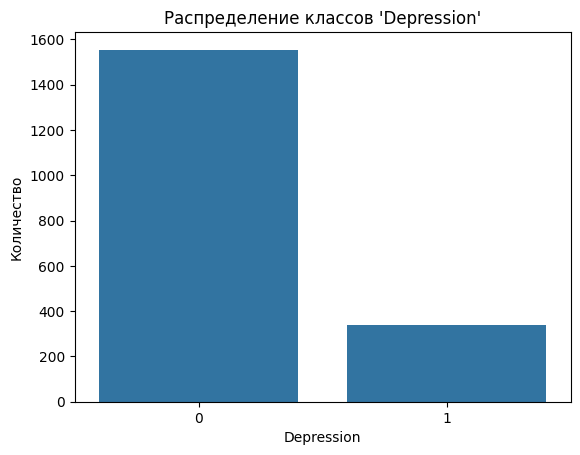

In [6]:
# Распределение целевой переменной
sns.countplot(x=y)
plt.title("Распределение классов 'Depression'")
plt.xlabel("Depression")
plt.ylabel("Количество")
plt.show()

In [ ]:
combined = pd.concat([train, test], axis=0)

for col in combined.select_dtypes(include='object').columns:
    combined[col] = combined[col].astype(str)

label_encoders = {}
for col in combined.select_dtypes(include='object').columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoders[col] = le

imputer = SimpleImputer(strategy="median")
combined_imputed = imputer.fit_transform(combined)

X_train = combined_imputed[:len(y)]
X_test = combined_imputed[len(y):]

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y)

test_preds = model.predict(X_test)

output = pd.DataFrame({
    'id': test_ids,    
    'Depression': test_preds
})

output.to_csv('predictions_random_trees.csv', index=False)

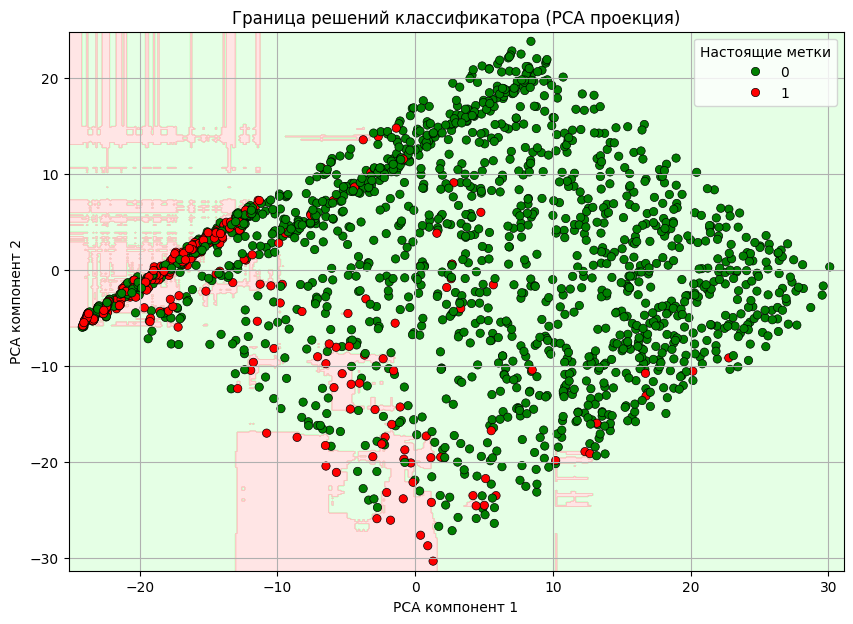

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
model_pca.fit(X_pca, y)

# Шаг 3: создаём сетку для фона
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# Получаем предсказания на сетке
Z = model_pca.predict(grid)
Z = Z.reshape(xx.shape)

#  визуализация
plt.figure(figsize=(10, 7))
cmap_background = ListedColormap(['#C0FFC0', '#FFC0C0'])  # зелёный/красный фон
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.4)

# Накладываем точки по истинным меткам
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["green", "red"], edgecolor='k')
plt.title("Граница решений классификатора (PCA проекция)")
plt.xlabel("PCA компонент 1")
plt.ylabel("PCA компонент 2")
plt.legend(title="Настоящие метки")
plt.grid(True)
plt.show()


In [ ]:
combined = pd.concat([train, test], axis=0)

mask_work = combined["Working Professional or Student"] == "Working Professional"
combined.loc[mask_work, "Academic Pressure"] = combined.loc[mask_work, "Academic Pressure"].fillna(0)

for col in combined.select_dtypes(include='object').columns:
    combined[col] = combined[col].astype(str)

label_encoders = {}
for col in combined.select_dtypes(include='object').columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoders[col] = le

imputer = SimpleImputer(strategy="median")
combined_imputed = imputer.fit_transform(combined)

X_train = combined_imputed[:len(y)]
X_test = combined_imputed[len(y):]#стало только хуже.
